## Main Implementation:

In [1]:
import numpy as np
from math import exp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ffnn:

    def __init__(self, a=0.01, epochs=10, shape = [784,28, 14, 7, 5], samples=1):
        """[STEP 1]
        When creating the FFNN the user can define the #neuron, #layers,
        epochs, and learning rate
        """
        # User defined attributes
        self.a = a # (learning rate)
        self.epochs = epochs
        self.m = len(shape)-2 #number of hidden layers

        # Parameters of the normal distribution
        self.mean = 0
        self.std = .1

        # From input to hidden layer
        self.wh = []
        self.bh = []
        for i in range(self.m):
            self.wh.append(np.random.normal(self.mean, self.std, (shape[i], shape[i+1])))
            self.bh.append(np.random.normal(self.mean, self.std, (samples, shape[i+1])))
        
        # From hidden to output layer
        self.wo = np.random.normal(self.mean, self.std, (shape[-2], shape[-1]))
        self.bo = np.random.normal(self.mean, self.std, (samples, shape[-1]))

        # Temporary variables for backpropagation
        self.zh = [None for _ in range(len(shape)-2)]
        self.ah = [None for _ in range(len(shape)-2)]
        self.zo = None
        self.ao = None

        # For reporting
        self.loss_history = []

    def relu(self, X, a=0.01):
        return np.where(X > 0, X, a * X)

    def softmax(self, X):
        X_exp = np.exp(X - np.max(X, axis=1, keepdims=True))
        sm = X_exp / np.sum(X_exp, axis=1, keepdims=True)
        # Created [n x 5] array where each row includes probs for each class
        return sm
    
    def relu_der(self, X, a=0.01):
        derivative = np.ones_like(X)  
        derivative[X <= 0] = a  
        return derivative
    
    def batch_normalization(self, X, epsilon=1e-5): # to mitigate gradient explosion
        mean = np.mean(X, axis=0)
        variance = np.var(X, axis=0)
        X_norm = (X - mean) / np.sqrt(variance + epsilon)
        return X_norm


    def predict_proba(self, X):
            """[STEP 2]
            Here we do the forward step.
            """
            self.zh[0] = X @ self.wh[0] + self.bh[0]
            self.ah[0] = self.batch_normalization(self.zh[0]) # reduce extreme outliers of weight/biases
            self.ah[0] = self.relu(self.ah[0])

            for i in range(1, self.m):
                self.zh[i] = self.ah[i-1] @ self.wh[i] + self.bh[i]
                self.ah[i] = self.batch_normalization(self.zh[i]) # ~
                self.ah[i] = self.relu(self.ah[i])

            # From hidden to output layer
            self.zo = self.ah[-1] @ self.wo + self.bo

            self.ao = self.softmax(self.zo)
            
            return self.ao
        
    def backpropagate(self, X, y):
            """[STEP 3]
            Find the gradient of each parameter
            and use it to update its actual value.
            """
            dL_dzo = self.ao - y # y also 10000 x 5 (make separately)
            dzo_dwo = self.ah[-1] 

            # - gradients of the weights in the second layer
            dL_dwo = dzo_dwo.T @ dL_dzo
            dL_dbo = dL_dzo.sum(axis=0).reshape(1,-1)

                # --- layer n-1 --------------------------------------------
            dzo_dah = self.wo
            dL_dah = dL_dzo @ dzo_dah.T

            self.wo -= self.a * dL_dwo
            self.bo -= self.a * dL_dbo

            # ---------------------------------------------------------------
                
            for i in range(self.m - 1, -1, -1): #iterate backworks until 0 (first hidden layer)
                dah_dzh = self.relu_der(self.zh[i])  # activation
                dL_dzh = dL_dah * dah_dzh

                if i == 0:
                    dzh_dwh = X  # Input to the first hidden layer
                else:
                    dzh_dwh = self.ah[i - 1]  # Output of the previous hidden layer

                dL_dwh = dzh_dwh.T @ dL_dzh
                dL_dbh = dL_dzh.sum(axis=0, keepdims=True)

                # Update weights and biases for hidden layer i
                self.wh[i] -= self.a * dL_dwh
                self.bh[i] -= self.a * dL_dbh

                # Backpropagate to the next earlier layer
                if i > 0:
                    dzh_dah = self.wh[i]  # Gradient of zh[i] with respect to ah[i-1]
                    dL_dah = dL_dzh @ dzh_dah.T
    
    def fit(self, X, y):
        """[STEP 4]
        Put it all together.
        """
        self.loss_history = []
        for e in range(self.epochs):

            # Forward pass
            p = self.predict_proba(X)

            # Backward pass
            self.backpropagate(X, y)

            # Track progress
            self.loss_history.append(self.loss(y))
    
    def loss(self, y):
        """
        Implementation of loss function (cross entropy)
        """
        return -np.sum(y * np.log(self.ao + 1e-8)) / y.shape[0]


    def predict(self, X):
        """
        Implementation of the predict function that outputs label for each
        sample.
        """
        return np.argmax(self.predict_proba(X), axis=1)
        
    def accuracy(self, X, y):
        """
        Calculate the accuracy of the model on a given dataset.
        """
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

## Training and testing model
#### Training data

In [3]:
inp = np.load('fashion_train.npy')
data = inp[:,-1]
y = np.zeros((10000,5))
x = inp[:,:-1] #training features (784 pixels)

for i,j in enumerate(data): #transform labels into one-hot encoding
    y[i,j] = 1

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

#### Test data

In [4]:
test = np.load('fashion_test.npy')
X_test = test[:,:-1]
y_test = test[:,-1]

#### Testing FFNN

In [18]:
# Initialize classifier
clf = ffnn(a=0.0001, epochs=500, shape=[784,128, 64, 32, 5])

# Train
clf.fit(x, y)
clf

In [19]:
ypred = clf.predict(X_test)
np.unique(ypred, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([1416,  944,  983,  930,  727], dtype=int64))

Test Accuracy: 0.7626


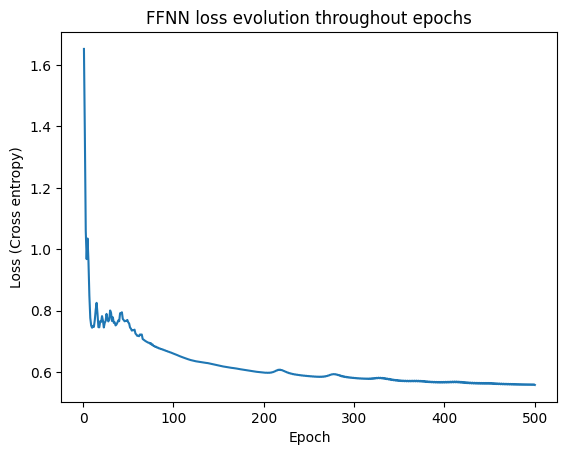

In [20]:
# Show the loss history
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1, clf.epochs + 1, 1), y = clf.loss_history, ax=ax)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Cross entropy)")
ax.set_title("FFNN loss evolution throughout epochs")

# Report the accuracy on the test set
test_accuracy = clf.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

#### More specific performance metrics 

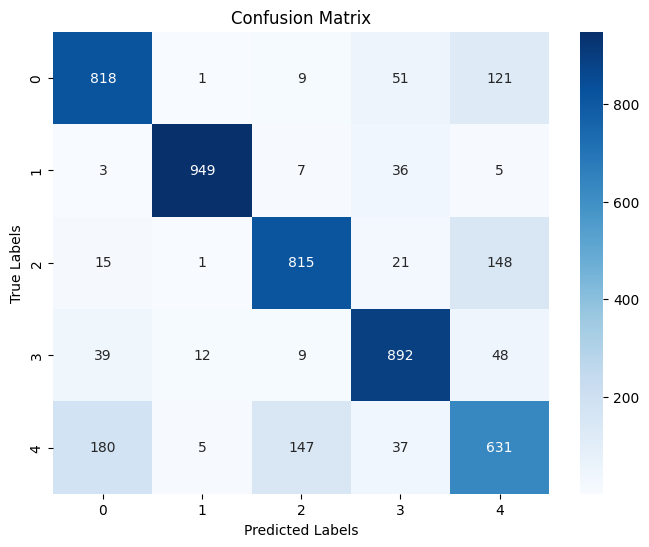

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, ypred)
    
    # Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
